# 09-04 Skip-Gram with Negative Sampling, SGNS 

# (네거티브 샘플링을 이용한 Word2Vec 구현)


출처: https://wikidocs.net/69141

gensim 패키지에서 제공하는 이미 구현된 Word2Vec을 사용하여 영어와 한국어 데이터를 학습합니다.


## 1.네거티브 샘플링(Negative Sampling)


만약 단어 집합의 크기가 수만 이상에 달한다면 이 작업은 굉장히 무거운 작업이므로, Word2Vec은 꽤나 학습하기에 무거운 모델이 됩니다.

Word2Vec은 역전파 과정에서 모든 단어의 임베딩 벡터값의 업데이트를 수행하지만, 

만약 현재 집중하고 있는 중심 단어와 주변 단어가 '강아지'와 '고양이', '귀여운'과 같은 단어라면, 

### 별 연관 관계가 없는 '돈가스'나 '컴퓨터'와 같은 수많은 단어의 임베딩 벡터값까지 업데이트하는 것은 비효율적

네거티브 샘플링은 Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법

'고양이', '귀여운 <-> 돈가스, 컴퓨터, 회의실과 같은 무작위로 선택된 단어들을 일부 가져옴. 

하나의 중심 단어에 대해서 
전체 단어 집합보다 훨씬 작은 단어 집합을 만들어놓고 마지막 단계를 이진 분류 문제로 변환

기존의 단어 집합의 크기만큼의 선택지를 두고 다중 클래스 분류 문제를 풀던 Word2Vec보다 훨씬 연산량에서 효율적

# 2. 네거티브 샘플링 Skip-Gram(Skip-Gram with Negative Sampling, SGNS)

Skip-gram은 중심 단어 cat으로부터 주변 단어 The, fat, sat, on을 예측

< - > . SGNS는 다음과 같이 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지 그 확률을 예측

예) cat, sat 입력 -> skipgram(Negative Sampling) -> 0.88 (이웃관계일 확률) 

The fat cat sat on the mat

중심단어 cat - The, fat, sat, on, the, mat 레이블 1
               pizza, computer 레이블 0 -주변단어가 아님. 




In [1]:
from IPython.display import Image

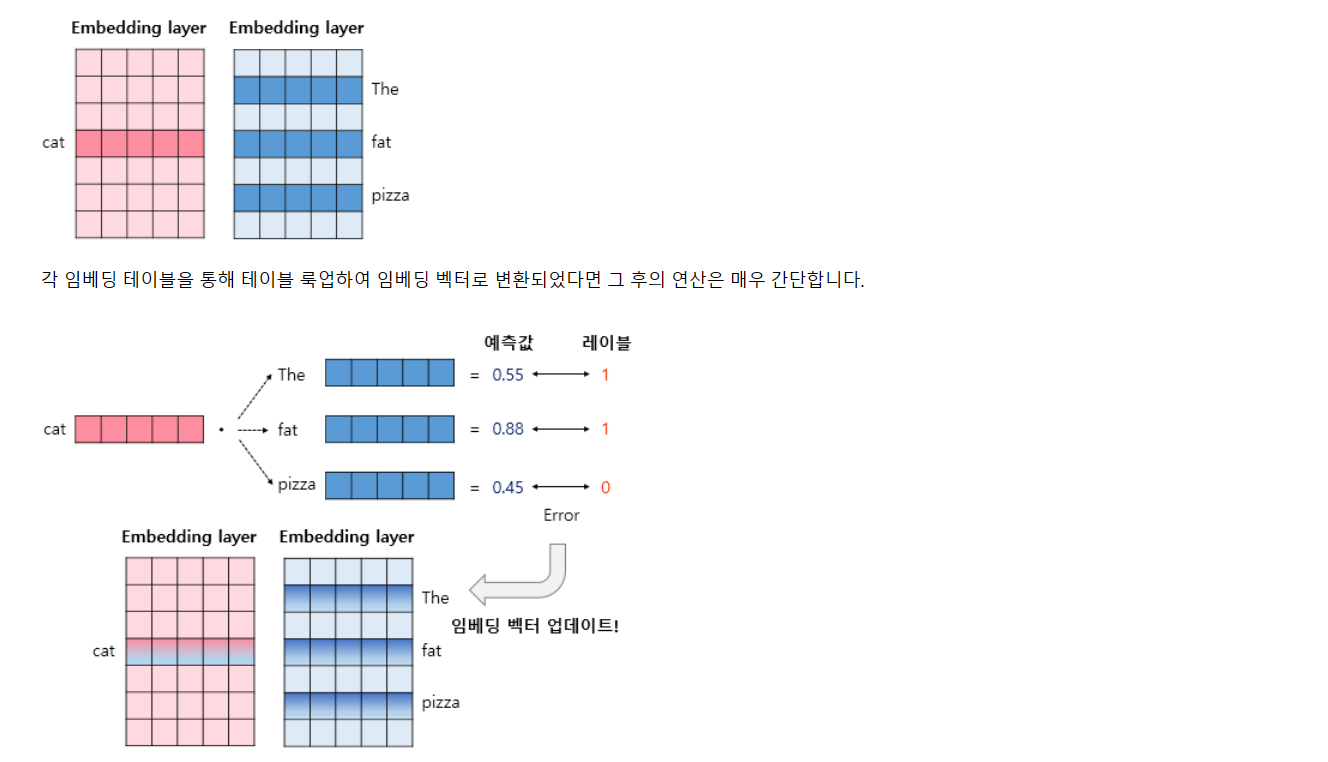

In [2]:
Image("image/09-04 Negative sampling.png")

# 3. 20뉴스그룹 데이터 전처리하기

20뉴스그룹 데이터를 사용합니다. 이번 실습에서는 하나의 샘플에 최소 단어 2개

그래야만 중심 단어, 주변 단어의 관계가 성립하며 그렇지 않으면 샘플을 구성할 수 없어 에러가 발생합니다. 전처리 과정에서 지속적으로 이를 만족하지 않는 샘플들을 제거하겠습니다.

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


총 샘플 수는 11,314개입니다. 전처리를 진행해봅시다. 
불필요한 토큰을 제거하고, 소문자화를 통해 정규화를 진행합니다.

In [3]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

C:\Users\USER\AppData\Local\Temp\ipykernel_3048\1763500723.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [4]:
news_df.isnull().values.any()
# 현재 데이터프레임에 Null 값이 있는지 확인합니다.



False

Null 값이 없지만, 빈 값(empy) 유무도 확인해야 합니다. 모든 빈 값을 Null 값으로 변환하고, 다시 Null 값이 있는지 확인합니다.

In [5]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [6]:
# Null 값이 있음을 확인했습니다. Null 값을 제거합니다.

news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [7]:
# 샘플 수가 일부 줄어든 것을 확인할 수 있습니다. 
# NLTK에서 정의한 불용어 리스트를 사용하여 불용어를 제거합니다.

# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [8]:
# 불용어를 제거하였으므로 단어의 수가 줄어들었습니다. 
# 모든 샘플 중 단어가 1개 이하인 경우를 모두 찾아 제거하겠습니다.

# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


C:\Users\USER\anaconda3\envs\la1\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [9]:
# 샘플 수가 다시 줄어들었습니다. 단어 집합을 생성하고, 정수 인코딩을 진행합니다.

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [10]:
# 상위 2개의 샘플을 출력해봅시다.

print(encoded[:2])


[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [11]:
# 단어 집합의 크기를 확인합니다.

vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


# 4. 네거티브 샘플링을 통한 데이터셋 구성하기

토큰화, 정제, 정규화, 불용어 제거, 정수 인코딩까지 일반적인 전처리 과정을 거쳤습니다. 네거티브 샘플링을 통한 데이터셋을 구성할 차례

이를 위해서는 네거티브 샘플링을 위해서 케라스에서 제공하는 전처리 도구인 skipgrams를 사용합니다. 어떤 전처리가 수행되는지 그 결과를 확인하기 위해서 (꽤 시간이 소요되는 작업이므로) 상위 10개의 뉴스그룹 샘플에 대해서만 수행

In [12]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [13]:
# 결과를 확인합니다. 10개의 뉴스그룹 샘플에 대해서 모두 수행되었지만, 첫번째 뉴스그룹 샘플에 대해서만 확인해보겠습니다.

# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(report (581), pziakpx (38490)) -> 0
(story (603), vaya (45802)) -> 0
(government (51), acts (1102)) -> 1
(israels (13686), griffiths (18639)) -> 0
(media (702), seem (207)) -> 1


In [14]:
# 윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블을 갖도록 하고, 그렇지 않은 경우는 0의 레이블을 가지도록 하여 데이터셋을 구성합니다. 
# 이 과정은 각각의 뉴스그룹 샘플에 대해서 동일한 프로세스로 수행됩니다.

print('전체 샘플 수 :',len(skip_grams))


전체 샘플 수 : 10


encoded 중 상위 10개의 뉴스그룹 샘플에 대해서만 수행하였으므로 10이 출력됩니다. 그리고 10개의 뉴스그룹 샘플 각각은 수많은 중심 단어, 주변 단어의 쌍으로 된 샘플들을 갖고 있습니다. 첫번째 뉴스그룹 샘플이 가지고 있는 pairs와 labels의 개수를 출력해봅시다.

In [15]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


In [24]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

# 5. Skip-Gram with Negative Sampling(SGNS) 구현하기



In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [27]:
# 하이퍼파라미터인 임베딩 벡터의 차원은 100으로 정하고, 두 개의 임베딩 층을 추가합니다.

embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 100)       6427700     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 100)       6427700     ['input_4[0][0]']                
                                                                                            

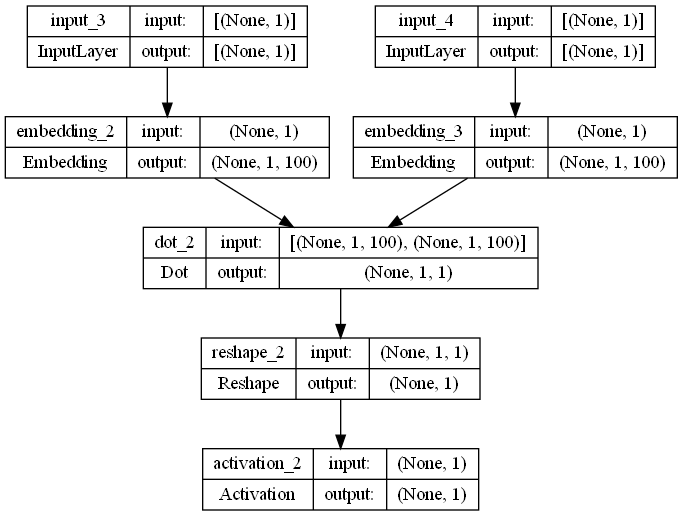

In [30]:
# 각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며 각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 
# 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻습니다.

dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [31]:
# 모델의 학습은 5에포크 수행하겠습니다.



for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4280.883463699371
Epoch : 2 Loss : 3648.590108903125
Epoch : 3 Loss : 3476.9730161186308
Epoch : 4 Loss : 3254.6532442746684
Epoch : 5 Loss : 3018.6729376188014


# 6. 결과 확인하기

학습된 모델의 결과를 확인해보겠습니다. 학습된 임베딩 벡터들을 vector.txt에 저장합니다. 그 후 이를 gensim의 models.KeyedVectors.load_word2vec_format()으로 로드하면 쉽게 단어 벡터 간 유사도를 구할 수 있습니다.



In [37]:
import gensim


In [38]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [39]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)


In [40]:
w2v.most_similar(positive=['disease'])


[('quack', 0.6804531216621399),
 ('lyme', 0.6760699152946472),
 ('yeast', 0.6662485599517822),
 ('physician', 0.6249382495880127),
 ('medicine', 0.6221098303794861),
 ('patient', 0.6202043890953064),
 ('patients', 0.6156920790672302),
 ('therapy', 0.6057749390602112),
 ('doctrines', 0.594524085521698),
 ('infections', 0.5935437083244324)]

In [41]:
w2v.most_similar(positive=['soldiers'])


[('wounded', 0.8275314569473267),
 ('refugees', 0.802677571773529),
 ('agdam', 0.7890929579734802),
 ('civilians', 0.7815434336662292),
 ('moslems', 0.7808460593223572),
 ('shelling', 0.779812753200531),
 ('jewry', 0.7726760506629944),
 ('corpses', 0.7717857360839844),
 ('lacin', 0.7690551280975342),
 ('attacking', 0.7687557339668274)]

In [42]:
w2v.most_similar(positive=['police'])


[('populations', 0.6720495223999023),
 ('officers', 0.6412981152534485),
 ('undermining', 0.6304070353507996),
 ('united', 0.6033639907836914),
 ('organizations', 0.5986198782920837),
 ('endorsed', 0.592861533164978),
 ('represented', 0.5891709327697754),
 ('democratic', 0.5826197266578674),
 ('discrimination', 0.5810239315032959),
 ('allies', 0.579405665397644)]

In [43]:
w2v.most_similar(positive=['hero'])


[('hired', 0.6837772727012634),
 ('opportunities', 0.6821958422660828),
 ('canucks', 0.6713261008262634),
 ('roenick', 0.6658337116241455),
 ('tuesday', 0.6513862609863281),
 ('powerplay', 0.6463703513145447),
 ('calgary', 0.645497739315033),
 ('escaped', 0.6453885436058044),
 ('quebec', 0.644424319267273),
 ('murray', 0.6361697316169739)]

In [44]:
w2v.most_similar(positive=['engine'])


[('miles', 0.6797626614570618),
 ('nissan', 0.6292205452919006),
 ('toyota', 0.6033415794372559),
 ('sentra', 0.5787560343742371),
 ('suspension', 0.5681070685386658),
 ('door', 0.566234827041626),
 ('dealership', 0.5556281208992004),
 ('tires', 0.5477365255355835),
 ('explorer', 0.5344566106796265),
 ('bikes', 0.5294750928878784)]

In [45]:
w2v.most_similar(positive=['doctor'])


[('lyme', 0.5894631147384644),
 ('patients', 0.585861325263977),
 ('pain', 0.5832964777946472),
 ('vehemently', 0.5749202370643616),
 ('intoxication', 0.5530296564102173),
 ('organism', 0.5500353574752808),
 ('medication', 0.5474767684936523),
 ('acute', 0.5456468462944031),
 ('therapy', 0.5455714464187622),
 ('positives', 0.5411019325256348)]

In [46]:
w2v.most_similar(positive=['knife'])


[('taxation', 0.6647554636001587),
 ('murdering', 0.6473735570907593),
 ('fleeing', 0.6426507830619812),
 ('justify', 0.6400473117828369),
 ('reno', 0.6354326009750366),
 ('refuge', 0.6331155300140381),
 ('proved', 0.6330696940422058),
 ('semitic', 0.631110429763794),
 ('violations', 0.6259700059890747),
 ('prowess', 0.6243618130683899)]